## Model lasy drzew decyzyjnych

### 1. Argumenty za przyjęciem modelu lasu drzew decyzyjnych:
- zdolność radzenia sobie z dużą liczbą cech
- ddolność uwzględniania nieliniowych relacji
- duża odporność na nadmierne dopasowanie
- łatwość interpretacji

### 2. Import bibliotek oraz danych z plików .csv

In [43]:
# Standard libraries
import logging
import math

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz, plot_tree
from sklearn.utils.class_weight import compute_class_weight
from typing import Any, Dict, Optional, Tuple

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [44]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    # Load data from CSV files
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    # Log data information
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    # Preprocess data using the specified scaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y


In [45]:

def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.10 * max_count), count) for class_label, count in zip(unique, counts)}

def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

def evaluate_model(X_train: np.ndarray, y_train: np.ndarray, model: Any, cv_splits: int = 5, random_state: int = 2137) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    accuracy_scores = []
    
    for train_index, test_index in kfold.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, y_pred)
        accuracy_scores.append(accuracy)
        logging.info(f"Accuracy for this fold: {accuracy * 100:.2f}%")

    mean_accuracy = np.mean(accuracy_scores)
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

def optimize_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, estimator: Any, param_grid: Dict[str, Any], n_iter: int = 10, cv_splits: int = 2, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=n_iter, cv=cv_splits, scoring='accuracy', random_state=random_state)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    return random_search.best_params_

def cross_validation_with_optimized_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42, model_name: str = 'GaussianNB') -> Dict[str, Any]:
    model.set_params(**best_params)
    pipe = make_pipeline(model)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    return cv_results

def evaluate_initial_model(X: np.ndarray, y: np.ndarray, model: Any) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X, y, model)
    logging.info(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
    logging.info(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

In [46]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

def plot_confusion_matrix(cm, classes, ax: plt.Axes) -> None:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

2024-05-30 23:01:36,157 - INFO - X shape: (1503, 5), y shape: (1503,)
2024-05-30 23:01:36,157 - INFO - Data scaled using standard scaler.
2024-05-30 23:01:36,157 - INFO - Data initialization and splitting complete.
2024-05-30 23:01:36,431 - INFO - Accuracy for this fold: 76.30%
2024-05-30 23:01:36,653 - INFO - Accuracy for this fold: 62.09%
2024-05-30 23:01:36,908 - INFO - Accuracy for this fold: 66.19%
2024-05-30 23:01:37,146 - INFO - Accuracy for this fold: 63.81%
2024-05-30 23:01:37,351 - INFO - Accuracy for this fold: 63.33%
2024-05-30 23:01:37,351 - INFO - Mean accuracy score over all folds: 66.34%
2024-05-30 23:01:37,351 - INFO - Accuracy for the last fold: 63.33%
2024-05-30 23:01:49,178 - INFO - Best accuracy score: 63.69%
2024-05-30 23:01:49,179 - INFO - Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
2024-05-30 23:01:53,487 - INFO - Cross-validation results: {'fit_time': array([0.81961036, 0.80858517, 

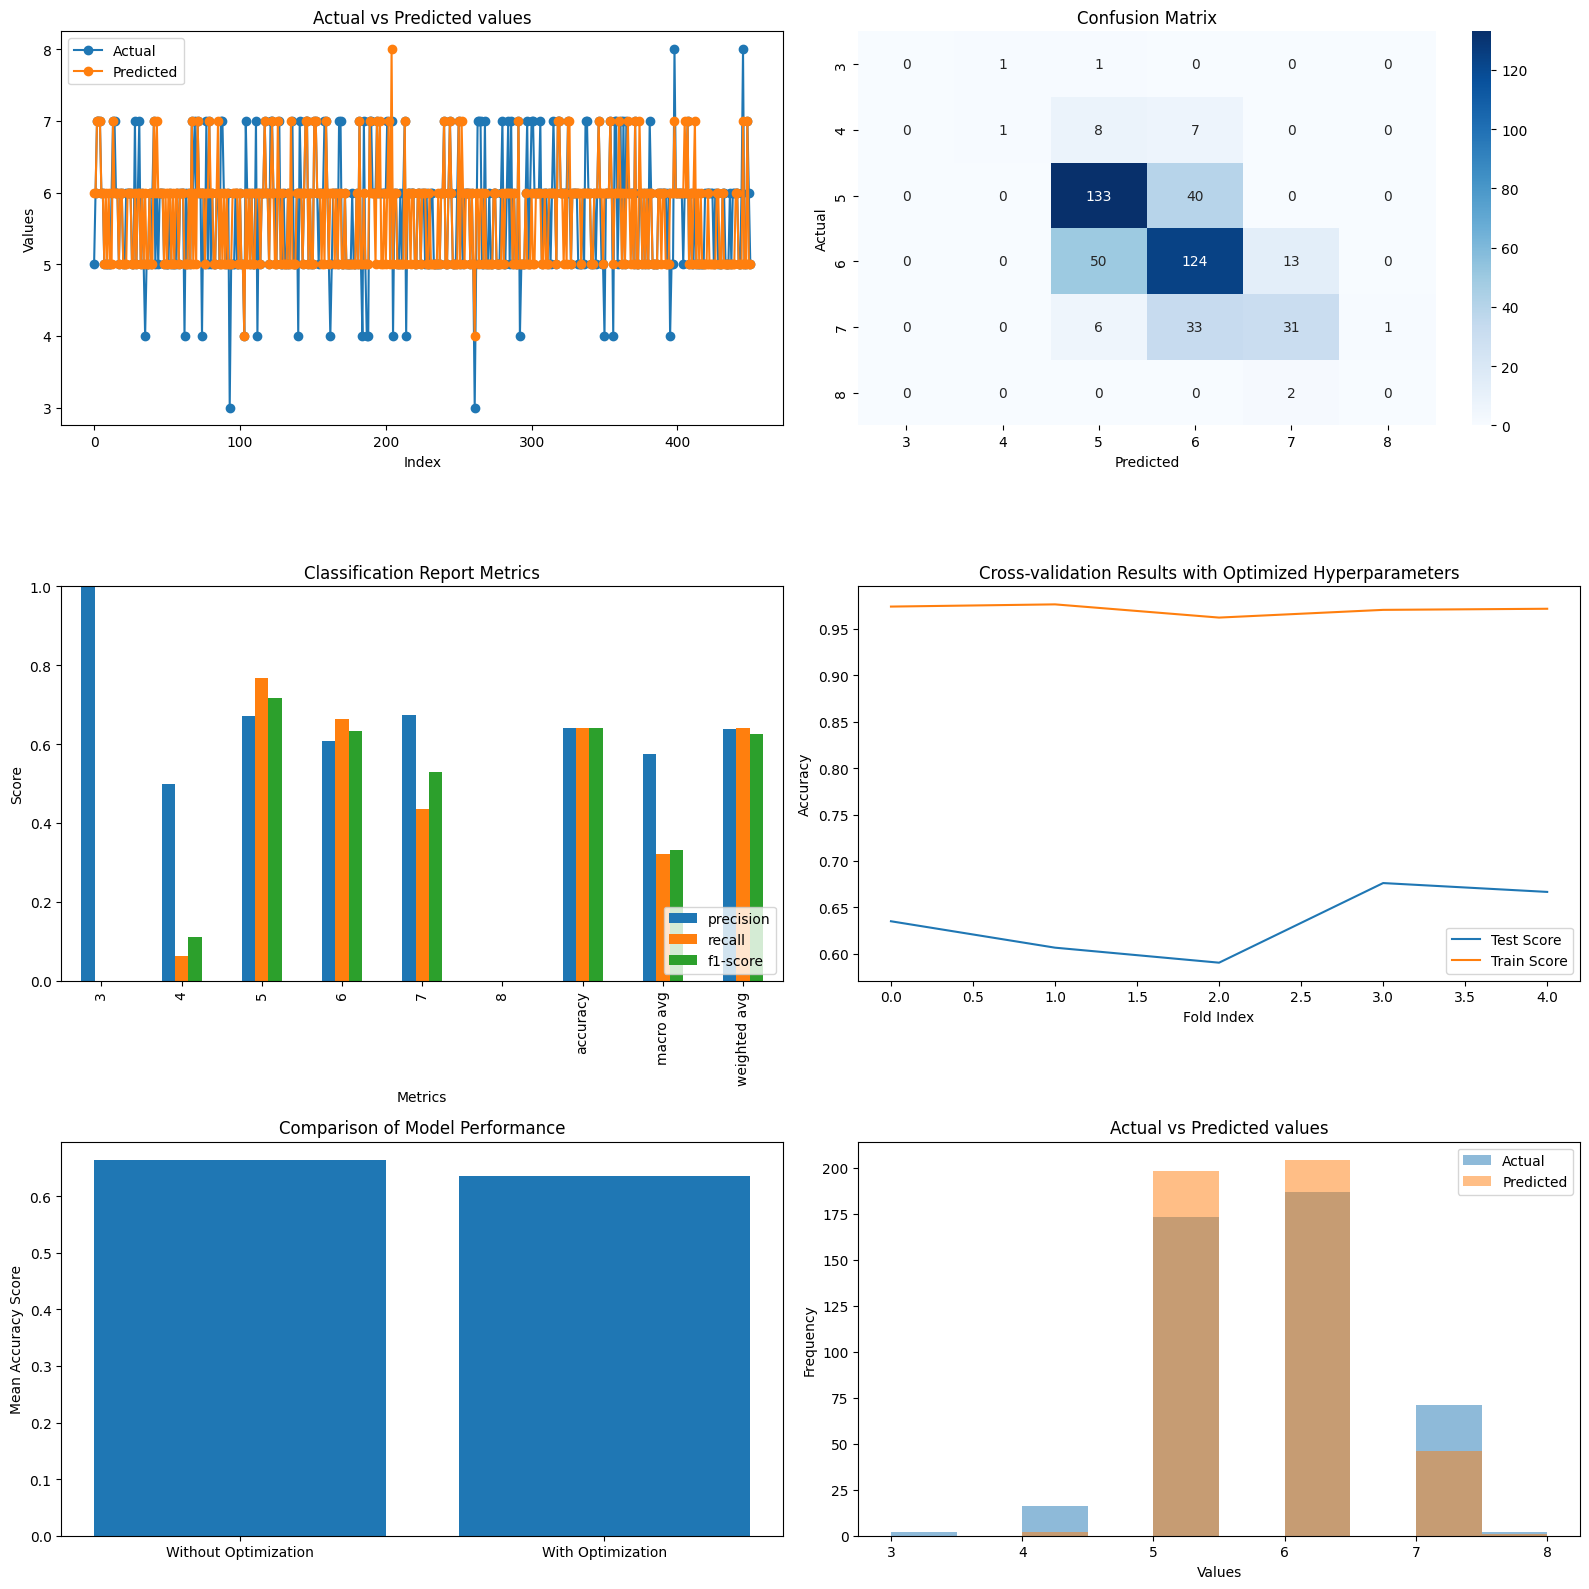

In [47]:
from sklearn.ensemble import RandomForestClassifier

def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    best_params = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best parameters: {best_params}")
    return best_params

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='RandomForest')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def random_forest_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none')
        logging.info("Data initialization and splitting complete.")

        # Scale data
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

        # Initial Model Evaluation
        rf = RandomForestClassifier()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train_scaled, y_train, rf)
        accuracy_without_optimization = mean_accuracy

        # Hyperparameter Tuning
        best_params = perform_hyperparameter_optimization(X_train_scaled, y_train, rf)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train_scaled, y_train, rf, best_params)
        accuracy_with_optimization = cv_results['test_score'].mean()

        # Retrain the model with the optimized parameters and make predictions on the test set
        rf.set_params(**best_params)
        rf.fit(X_train_scaled, y_train)
        y_pred_optimized = rf.predict(X_test_scaled)

        # Report Generation for the Optimized Model
        report_optimized = generate_report(y_test, y_pred_optimized)

        # Display plots for the optimized model
        display_plots(y_test, y_pred_optimized, report_optimized, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    random_forest_main()

In [48]:
# Y_combined = pd.concat([y_train, y_test], ignore_index=True)
# class_names = Y_combined['quality'].unique().tolist()
# class_names_str = list(map(str, class_names)) 


# plt.figure(figsize=(20, 10))
# for i in range(len(rf.estimators_)):
#     plt.subplot(1, len(rf.estimators_), i + 1)
#     plot_tree(rf.estimators_[i], feature_names=X_test.columns.tolist(), class_names=class_names_str, filled=True)
#     plt.title(f'Decision Tree {i+1}')

# plt.tight_layout()
# plt.show()